# Take in the adult dataset, process it through 1D SOM, give back dataset with new feature being 1D cluster label

Import the needed modules and load the dataset

In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import tqdm
import numba

import glob
import os
from dataclasses import dataclass
from typing import List, Optional

from itertools import product

from collections import OrderedDict

from sklearn.preprocessing import minmax_scale

np.random.seed(1337)

## Load the adult dataset with minimal preprocessing

### Description of adult dataset features

- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.


In [2]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
                'hours_per_week', 'native_country', 'income_class']

len(column_names)

15

In [3]:
adult_df = pd.read_csv('data/adult.data', names=column_names, encoding='ascii')

# Drop whitespace before strings
# applymap will check every value in the dataframe and strip whitespace
# only on strings, leaving others unchanged
adult_df = adult_df.applymap(lambda v: v.strip() if type(v) == str else v)

# Encode the income class as a number so it won't cause a problem later when 
# doing pd.get_dummies
adult_df['income_class'] = adult_df['income_class'].map({'<=50K': 0, '>50K': 1})

# Drop the weird fnlwgt columns (It is probably zipcode, maybe droping is not a good idea)
# adult_df.drop('fnlwgt', axis=1, inplace=True)

# Order in correct order so distance can later be calculated easier
adult_df = adult_df[['marital_status', 'native_country',  'occupation',
                     'workclass', 'relationship', 'race', 'sex',
                     'age', 'education_num', 'capital_gain', 'capital_loss', 'fnlwgt',
                     'hours_per_week', 'income_class'
                    ]]

adult_df.head()

,marital_status,native_country,occupation,workclass,relationship,race,sex,age,education_num,capital_gain,capital_loss,fnlwgt,hours_per_week,income_class
0,Never-married,United-States,Adm-clerical,State-gov,Not-in-family,White,Male,39,13,2174,0,77516,40,0
1,Married-civ-spouse,United-States,Exec-managerial,Self-emp-not-inc,Husband,White,Male,50,13,0,0,83311,13,0
2,Divorced,United-States,Handlers-cleaners,Private,Not-in-family,White,Male,38,9,0,0,215646,40,0
3,Married-civ-spouse,United-States,Handlers-cleaners,Private,Husband,Black,Male,53,7,0,0,234721,40,0
4,Married-civ-spouse,Cuba,Prof-specialty,Private,Wife,Black,Female,28,13,0,0,338409,40,0


In [4]:
adult_df.shape

(32561, 14)

In [5]:
adult_df.dtypes

marital_status    object
native_country    object
occupation        object
workclass         object
relationship      object
race              object
sex               object
age                int64
education_num      int64
capital_gain       int64
capital_loss       int64
fnlwgt             int64
hours_per_week     int64
income_class       int64
dtype: object

## Use one-hot encoding to get binary values everywhere

Inside our SOM implementation we use one-hot encoded vectors and cosine distance.

In [6]:
# adult_df_encoded = pd.get_dummies(adult_df)
adult_df_encoded=adult_df.drop(['marital_status', 'native_country',  'occupation',
                     'workclass', 'relationship', 'race', 'sex'], axis=1)
adult_df_encoded_X = adult_df_encoded.drop('income_class', axis=1)
adult_df_encoded_y = adult_df_encoded['income_class']

In [7]:
adult_df_encoded_X.head()

,age,education_num,capital_gain,capital_loss,fnlwgt,hours_per_week
0,39,13,2174,0,77516,40
1,50,13,0,0,83311,13
2,38,9,0,0,215646,40
3,53,7,0,0,234721,40
4,28,13,0,0,338409,40


In [8]:
adult_df_encoded_y.head()

0    0
1    0
2    0
3    0
4    0
Name: income_class, dtype: int64

### normalize to 0 - 1 range

The reason for normalization is that all features are from 0 to 1 and as such cosine distance will work as intended.

In [9]:
adult_df_encoded_normalized = minmax_scale(adult_df_encoded_X)
adult_df_encoded_normalized = pd.DataFrame(adult_df_encoded_normalized, 
                                           columns=adult_df_encoded_X.columns)

adult_df_encoded_normalized.head()

,age,education_num,capital_gain,capital_loss,fnlwgt,hours_per_week
0,0.301370,0.800000,0.02174,0.0,0.044302,0.397959
1,0.452055,0.800000,0.00000,0.0,0.048238,0.122449
2,0.287671,0.533333,0.00000,0.0,0.138113,0.397959
3,0.493151,0.400000,0.00000,0.0,0.151068,0.397959
4,0.150685,0.800000,0.00000,0.0,0.221488,0.397959


## Taxonomy trees

The function `memoize` is a python decorator which will cache the results of its input, and for the same input in a later point in time return the cached result.

Due to the specific scenario this function is used in the caching works on `args[1:]`, specifically on the values of the tree nodes, if such are present. Note that `self` is the first argument and thus one has to use `args[1:]`

The cache is a python dictionary which has O(1) insert and access behaviours as it is implement via hashmaps.

In [10]:
def memoize(func):
    cache = {}
    def memoized(*args):
        cache_key = args[1:]
        cache_key = tuple(k.value if k is not None else None for k in cache_key)
        
        if cache_key in cache.keys():
            return cache[cache_key]
        else:
            val = func(*args)
            cache[cache_key] = val
            return val
    return memoized

The taxonomy tree is formed from multiple nodes, starting from `root`.

Each node has three fields:
- *value*, the label held in this node (e.g. Married)
- *children*, a list of all children of this node, it is empty for leaf nodes
- *parent*, a node which is the parent of this node (e.g. Married has parent '\*', the root))

In addition there are two methods:
- \_\_repr\_\_ which is just the python standard way to display objects as strings
- height which determines how deep this node is in the tree which containts it

For a referesher on trees here is a good youtube video:
- https://www.youtube.com/watch?v=oSWTXtMglKE
- It is about binary search trees but it is a similar idea to what we do in this notebook

In [11]:
class TreeNode:
    def __init__(self, 
                 value: str,
                 children,
                 parent):
        self.value = value
        self.children = children
        self.parent = parent
        
    def __repr__(self):
        return f"{self.value} {self.children}"
    
    def height(self) -> int:
        if self.parent is None:
            return 0
        
        return 1 + self.parent.height()

In [12]:
# Dataclasses are a 'fancy' new way to automatically define the __init__ method
# https://docs.python.org/3/library/dataclasses.html
@dataclass
class Tree:
    # Every tree grows from the root which always has the value '*'
    root: TreeNode
    # Due to building the tree at once we can precalculate the height
    height: int
        
    def find_node(self, value: str) -> Optional[TreeNode]:
        """
        :param value str: Label to search for the in the tree.
        :return Optional[TreeNode]: Searches for the node which 
        has the requested label and returns it if found.
        Returns None otherwise.
        
        This is BFS (breadth first search) over the tree
        """
        # Start the search from the root
        queue = [self.root]
        
        while len(queue) > 0:
            node = queue.pop()
                        
            if node.value == value:
                return node
            
            for c in node.children:
                queue.append(c)
                
        return None
    
    def add_node(self, value: str, parent_value: str):
        """
        :param value str: The label of the new node we want to add
        :param parent_value str: The label of the parent, so we know where to add the new node.
        
        Find the parent and if possible add the children (i.e. it was not added before) 
        """
        # Find the parent node and this new node
        parent = self.find_node(parent_value)
        
        # Check if already present via any and a generator
        # the meaning here is that if any children has this label
        # it means it was added before
        was_already_added = any((c.value == value for c in parent.children))
        
        # If not added, add it as a new node with no children
        if not was_already_added:
            parent.children.append(TreeNode(value, [], parent))
        
    def add_path(self, path: List[str]):
        """
        :param path List[str]: One path as sequence of labels
        
        The data for adult taxonomy comes as paths. 
        This is a convenience method to add these
        paths to the tree.
        
        Note: The path is reversed so '*' comes first.
        """
        path = path[::-1]
        
        # The 'trick' zip(path, path[1:]) is very useful in working with paths
        # For example for path [1, 2, 3] it would give (1, 2) and (2, 3)
        # which is exactly the parent-child relationship we need
        for parent_value, value in zip(path, path[1:]):
            self.add_node(value.strip(), parent_value.strip())   
            
    @memoize
    def find_matching_parent(self, node1: TreeNode, node2: TreeNode) -> TreeNode:
        """
        This is the central method of the tree. 
        For two nodes in the tree it finds the closest matching parent as defined in the kmember paper.
        It works for a pair of nodes while it's extension in the method :ref find_matching_parent_many:
        works for more than 2 nodes.
        
        It is complex algorithm which calls itself recursively and it has the property that it calculates 
        the same thing multiple times. To avoid wasting time such cases are handled via a cache and the @memoize
        decorator. This algorithm is an example of top down dynamic programming.
        - https://www.youtube.com/watch?v=dZ0OS4YUs2A
        
        Here is the logic of the algorithm (fmp = find_matching_parent)
        
        fmp None None = root [no nodes in tree means matching parent is root]
        
        fmp x x = x [if both nodes are the same, return the first one]
        
        fmp x y where parent of x is equal to parent of y = parent of x [if parent directly above case]
        
        fmp root _ = root if we try to find parent of root we have to return root
        fmp _ root = root if we try to find parent of root we have to return root
        
        otherwise call the algorithm recursively on combinations of parents as the new nodes on which to check.
        There will be 3 possible choices, of which the one with largest height is selected as the matching parent.
        """
        # If the node does not exist in the tree, then the matching parent is set to be the root
        if node1 is None or node2 is None:
            return self.root
        
        # If the values are the same, they are the same node 
        # so parent for distance calculation purposes is the same one
        # as in paper
        if node1.value == node2.value:
            return node1
        
        # If the parent is directly above then just return it
        if node1.parent == node2.parent:
            return node1.parent
        
        # If we reached root, return it
        if node1.parent is None:
            return node1
        if node2.parent is None:
            return node2
        
        # Examine parent nodes for searching higher in the taxonomy tree
        o1 = self.find_matching_parent(node1, node2.parent)
        o2 = self.find_matching_parent(node1.parent, node2)
        o3 = self.find_matching_parent(node1.parent, node2.parent)
        
        # Pick the matching parent with largest height
        choices = [o1, o2, o3]
        choices = sorted(choices, key=lambda o: o.height(), reverse=True)
        
        return choices[0]
    
    def find_matching_parent_many(self, labels: List[str]) -> TreeNode:
        """
        :param labels List[str]: List of labels from which to search for parents.
        
        This algorithm is going pairwise over labels, finding the nodes, and finding
        the matching parent for them.
        
        Of all matching parents, the one with lowest distance is kept as the final result.
        """
        parents = set()
        
        for l1, l2 in product(labels, repeat=2):
            mp = self.find_matching_parent(self.find_node(l1), 
                                           self.find_node(l2))
            
            parents = parents | { mp }
            
        # Best parent is one with minimum height
        parent = min(parents, key=lambda n: n.height())
        
        return parent
    
    def all_nodes(self) -> List[TreeNode]:
        """
        Using BFS flatten the tree into a list of nodes
        """
        output = []
        queue  = [self.root]
        
        while len(queue) > 0:
            node = queue.pop()
            
            for c in node.children:
                queue.append(c)
                
            output.append(node)
                
        return list(set(output))

In [13]:
def read_tree(filepath: str) -> Tree:
    """
    :param filepath: From where to read.
    
    :return Tree: The fully grown taxonomy tree.
    
    Read a taxonomy tree from file.
    """
    with open(filepath, 'r') as f:
        ls = f.readlines()
        paths = [l.strip('\n').split(';') for l in ls]
        height = max(map(len, paths)) - 1
        
        root = TreeNode('*', [], None)
        tree = Tree(root, height)
        
        for path in paths:
            tree.add_path(path)
                        
        return tree
    
    
def read_all_trees():
    """
    Go over the files in data/trees/ directory and read them
    after parsing the attribute name from file name.
    """
    i = ((os.path.split(x)[1].strip('adult_').strip('.txt'), 
          read_tree(x)) 
         for x in glob.glob('data/trees/*.txt'))

    trees = OrderedDict(i)
    trees['sex'] = trees['se']
    del trees['se']
    
    return trees

trees = read_all_trees()

print('Example tree and list of categorical attributes')
trees['marital_status'], trees.keys()

Example tree and list of categorical attributes


(Tree(root=* [Never-married [], Married [Married-civ-spouse [], Married-AF-spouse []], leave [Divorced [], Separated []], alone [Widowed [], Married-spouse-absent []]], height=2),
 odict_keys(['relationship', 'race', 'workclass', 'native_country', 'marital_status', 'occupation', 'sex']))

With the taxonomy trees loaded we can define the distance between two labels using the appropriate tree.

In [14]:
def single_attr_distance(trees, attr_name, val1, val2, debug_print=True):
    """
    :param trees: dictionary holding all taxonomy trees, keyed by attribute name
    :param attr_name: the name of the attribute by which we find taxonomy distance
    :param val1: value of the attribute in record 1
    :param val2: value of the attribute in record 2
    
    :return: taxonomy tree distance for a single attribute
    """
    tree = trees[attr_name]
        
    node1 = tree.find_node(val1)
    node2 = tree.find_node(val2)
    
    if debug_print:
        print('Node 1', node1)
        print('Node 2', node2)
    
    mp    = tree.find_matching_parent(node1, node2)
    
    if debug_print:
        print('Matching parent', mp)
        print('Height of matching parent', mp.height())
    
    return 1.0 - mp.height() / tree.height
    
# Here we have debug output On so one can see what is going on.
print(single_attr_distance(trees, 'marital_status', 'Widowed', 'Widowed'))
print(single_attr_distance(trees, 'marital_status', 'Widowed', 'Separated'))
print(single_attr_distance(trees, 'marital_status', 'Separated', 'Widowed'))
print(single_attr_distance(trees, 'marital_status', 'Separated', 'Divorced'))

Node 1 Widowed []
Node 2 Widowed []
Matching parent Widowed []
Height of matching parent 2
0.0
Node 1 Widowed []
Node 2 Separated []
Matching parent * [Never-married [], Married [Married-civ-spouse [], Married-AF-spouse []], leave [Divorced [], Separated []], alone [Widowed [], Married-spouse-absent []]]
Height of matching parent 0
1.0
Node 1 Separated []
Node 2 Widowed []
Matching parent * [Never-married [], Married [Married-civ-spouse [], Married-AF-spouse []], leave [Divorced [], Separated []], alone [Widowed [], Married-spouse-absent []]]
Height of matching parent 0
1.0
Node 1 Separated []
Node 2 Divorced []
Matching parent leave [Divorced [], Separated []]
Height of matching parent 1
0.5


### Precalculate distances per attribute for all attributes

The taxonomy trees are necessary to calculate the distances but because there is only a finite set of labels, all distances could be precalculated and thus one will not have to use trees in the rest of the code.

One advantage of this is that working with numba should be easier with this.

These will be stored in one *global* dictionary named `single_attr_distances` whose keys are (attribute_name, label1, label2). An example key is 'marital_status', 'alone', 'Married'.

In [15]:
trees['marital_status'].all_nodes()

[* [Never-married [], Married [Married-civ-spouse [], Married-AF-spouse []], leave [Divorced [], Separated []], alone [Widowed [], Married-spouse-absent []]],
 Separated [],
 alone [Widowed [], Married-spouse-absent []],
 Married-civ-spouse [],
 Widowed [],
 Married-AF-spouse [],
 Married-spouse-absent [],
 Never-married [],
 Married [Married-civ-spouse [], Married-AF-spouse []],
 leave [Divorced [], Separated []],
 Divorced []]

In [16]:
categorical_attributes_order = ('marital_status', 'native_country', 'occupation', 'workclass', 'relationship', 'race', 'sex')

In [17]:
# Define the dictionary
single_attr_distances = {} 

# Populate the dictionary by going over every attribute.
for attr in tqdm.tqdm(categorical_attributes_order):  
    # Get all labels for one tree
    labels = [l.value for l in trees[attr].all_nodes()]
    
    # For each pair of labels calculate the distance
    for l1, l2 in product(labels, repeat=2):
        single_attr_distances[(attr, l1, l2)] = single_attr_distance(trees, attr, l1, l2, False)
        
    # Handle missing values cases
    for l in labels:
        single_attr_distances[(attr, '?', l)] = 1.0
        single_attr_distances[(attr, l, '?')] = 1.0

    # Distance between two missing values is 1.0, the maximal possible distance
    single_attr_distances[(attr, '?', '?')] = 1.0

print('Example for getting distance from the dictionary')
single_attr_distances[('marital_status', 'Widowed', 'Divorced')]

100%|██████████| 7/7 [00:00<00:00, 89.43it/s]

Example for getting distance from the dictionary


1.0

### Define the kmember distance function

We define a strict categorical ordering so we can use integer indices in the algorithms.

In [18]:
categorical_attributes_order = ('marital_status', 'native_country', 'occupation', 'workclass', 'relationship', 'race', 'sex')

In [19]:
# @numba.jit(nopython=False, parallel=True, fastmath=True, inline='always')
def taxonomy_tree_distance(record1_cats: np.ndarray, record2_cats: np.ndarray, single_attr_distances):
    """
    :param record1_cats: Is a numpy array of labels, one label for one attribute.
    :param record2_cats: Is a numpy array of labels, one label for one attribute.
    :param single_attr_distances: The dictionary with precalculated distances.
    
    This method implements the taxonomy tree distance as described in kmember paper.
    
    Essentialy it just sums the per attribute distances for given label pairs.
    """
    total = 0
    for i in range(len(categorical_attributes_order)):
        attr = categorical_attributes_order[i]
        val1 = record1_cats[i]
        val2 = record2_cats[i]
        d = single_attr_distances[(attr, val1, val2)]
        total += d
    return total

In [20]:
# Test that the function works.
# Notice that we cast into str to ensure maximum compatibility.
taxonomy_tree_distance(adult_df.iloc[0, :7].values.astype(str), 
                       adult_df.iloc[1, :7].values.astype(str), 
                       single_attr_distances)

4.0

The second compoment of kmember distance are full dataset ranges of numeric attributes.

These we compute in next cell and store in variable named `numerical_attribute_ranges`

In [21]:
# it goes to -1 so it will ignore income_class
# 7 is the index of the first numeric attribute
numerical_attribute_ranges = adult_df.iloc[:, 7:-1].max(axis=0) - adult_df.iloc[:, 7:-1].min(axis=0)

numerical_attribute_ranges = numerical_attribute_ranges.values

numerical_attribute_ranges

array([     73,      15,   99999,    4356, 1472420,      98])

In [22]:
# @numba.jit(nopython=False, parallel=False, fastmath=True, inline='never')
def kmember_distance(record1, record2, single_attr_distances):
    """
    Combine the taxonomy tree distance over categorical attributes
    and the ratio distance over numerics.
    
    Look into the kmember paper for more info.
    """
    cd = taxonomy_tree_distance(record1[:7], record2[:7], single_attr_distances)
    # notice no -1 here, assumes income class was dropped before call to this function.
    nd = np.abs((record1[7:].astype(np.float64) - record2[7:].astype(np.float64)) / numerical_attribute_ranges).sum()
    
    return cd + nd

In [23]:
kmember_distance(adult_df.iloc[0, :-1].values, adult_df.iloc[1, :-1], single_attr_distances)

4.451871050685607

## Define information loss

Per kmember paper.

In [24]:
def information_loss_cluster(data: pd.DataFrame) -> float:
    """
    :param data pd.DataFrame: A dataframe which is a subset of adult_df with income_df dropped.
    """
    n_points = data.shape[0]
        
    loss = 0

    # for categorical features
    # for all pairs of present labels find parents
    # of all parents find the one with lowest height
    # as the worst possible case
    # and have that as the parent for distance calculation
    for fid in range(len(categorical_attributes_order)):
        labels = data.iloc[:, fid].unique()
        attr   = categorical_attributes_order[fid]
        dists  = [] 
        for l1, l2 in product(labels, repeat=2):
            dists.append(single_attr_distances[(attr, l1, l2)]) 
            
        loss += (min(dists) if len(dists) > 0 else 0.0)

    # for numeric features find the ratio of range in cluster over
    # range in full dataset
    for fid in range(len(categorical_attributes_order), data.shape[1] - 1):
        v = data.iloc[:, fid].max() - data.iloc[:, fid].min()
        if np.isnan(v):
            v = 0.0
        v = v / numerical_attribute_ranges[fid - len(categorical_attributes_order)]
        loss += v

    loss *= n_points
    
    return loss

def information_loss(dataset: pd.DataFrame) -> float:
    n_clusters = dataset['equivalence_class'].nunique()
    
    total_loss = 0
    
    for cl_id in range(n_clusters):
        data = dataset[dataset.equivalence_class == cl_id].copy()
        
        loss = information_loss_cluster(data)
                
        total_loss += loss
        
    return total_loss

In [25]:
# test information loss on random cluster assignment
adult_df['equivalence_class'] = np.random.choice(np.arange(200), size=adult_df.shape[0])
print(information_loss(adult_df.drop('income_class', axis=1)))
adult_df.drop('equivalence_class', axis=1, inplace=True)

137731.2203373009


# Self Organising Map implementation

### Define a new custom distance function which works on both numeric and categorical data

Have only one of it and make sure it is decorated with numba.jit for speed.

In [26]:
# L1 distance
# @numba.jit("float64(float64[:], float64[:])", nopython=True)
# def custom_distance(a, b):
#     return np.sum(np.abs(a - b))

# L2 distance
# @numba.jit("float64(float64[:], float64[:])", nopython=True)
# def custom_distance(a, b):
#     return np.sum((a - b) ** 2)

In [27]:
# Cosine distance
@numba.jit("float64(float64[:], float64[:])", inline='always', 
           nopython=True, fastmath=True, parallel=True)
def custom_distance(a, b):
    return 1.0 - np.abs(np.dot(a, b) / (np.sqrt(np.sum(a ** 2) * np.sum(b ** 2))))

<ipython-input-27-e7153265b6f7>:5: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  return 1.0 - np.abs(np.dot(a, b) / (np.sqrt(np.sum(a ** 2) * np.sum(b ** 2))))


In [28]:
custom_distance(adult_df_encoded_normalized.values[0, :], adult_df_encoded_normalized.values[1, :])

0.05638406321170408

In [29]:
custom_distance(adult_df_encoded_normalized.values[0, :], adult_df_encoded_normalized.values[2, :])

0.027285412801464348

### Define a few helper functions

For SOM to work we will need the learning rate scheduler (which is exponential in our case)

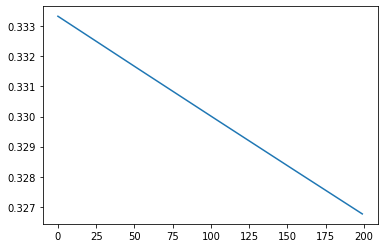

In [30]:
def learning_rate_decay_exponential(base=0.9999, const=3):
    def _f(s):
        return (base ** s) / const
    return _f
    
# Complicated code but it essentially just makes two arrays for plotting
__xs = np.arange(0, 200)
plt.plot(__xs, np.vectorize(learning_rate_decay_exponential())(__xs))

And the neighbourhood weighting function.

In [31]:
def neighbourhood_function_gaussian(sigma):
    """
    bmu_index is the integer index of the best matching index
    neighbour_index is the integer index of the neighbour under inspection
    s is the current iteration
    sigma is the standard deviation of the underlying gaussian
    """
    # note: s is ignored here
    def _f(bmu_index, neighbour_index, s): 
        return norm.pdf(x=neighbour_index, loc=bmu_index, scale=sigma)
    return _f
    
neighbourhood_function_gaussian(3)(5, 2, -1)

0.08065690817304778

Here is an example of how this function could look like for one specific Best Matching Unit index.

prob:  0 0.1 0.3 0.5 0.3 0.1 0

index: 0 1    2   3   4  5   6

bmu               idx

### The implementation of the SOM

In [32]:
@numba.jit("uint32(float64[:], float64[:,:])", 
           nopython=True, inline='always', 
           parallel=False, fastmath=True,
           target='cpu')
def find_bmu(input_vector, weight_vectors) -> int:   
    """
    :parent input_vector: One-hot encoded vector from the dataset.
    :param weight_vectors: Matrix of vectors, one vector per one neuron in SOM.
    
    Finds and returns the best matching unit for the given data point.
    BMU is the unit whose weight vector is closest to the input vector
    closest means minimum distance and in this function
     
    This algorithm is O(n) where n is the number of units/neurons in SOM.
    """
    md = 100000000.0
    bmu = -1
    for i in range(0, weight_vectors.shape[0]):
        d = custom_distance(weight_vectors[i, :], input_vector)
        if d <= md:
            md  = d
            bmu = i
                        
    return bmu

<ipython-input-27-e7153265b6f7>:5: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  return 1.0 - np.abs(np.dot(a, b) / (np.sqrt(np.sum(a ** 2) * np.sum(b ** 2))))


In [33]:
# Configure the function parameters of the SOM algorithm
# These can be left as they are here, the scheduler is OK while
# sigma for the neighbourhood function could perhaps get some change
# with different ks for k-annonimity
learning_rate_scheduler = learning_rate_decay_exponential(0.9999)
neighbourhood_function  = neighbourhood_function_gaussian(sigma=70)

In [34]:
def som_transform(dataset: pd.DataFrame,
                  desired_k: int = 50, 
                  max_iterations: Optional[int] = None) -> List[int]:
    """
    :param dataset: The dataframe
    :param desired_k: The level of annonymity desired. This algorithm does not guarantee it will be reached.
    :param max_iterations: Best left None so the algorithm uses a heuristic to determine how many iterations to work with.
    
    Train the SOM and assign BMUs to each point in the input dataframe.
    
    Returns a list of BMUs, one element of this list, corresponds to one row of the dataframe.
    """
    n_data_points      = dataset.shape[0]
    n_highdim_features = dataset.shape[1]
    
    # Based on the desired k-annonymity determine the number of 1D units
    n_units = n_data_points // desired_k
    
    if max_iterations is None:
        max_iterations = int(np.ceil(np.sqrt(n_data_points))) // 20
        
    print(f'Working with {n_units} units and going {max_iterations} times over the dataset')
        
    # Randomly initialized value vectors
    # Another option is PCA initialization
    # This could be improved through bernoulli sampling for the 0/1 encoded columns
    weight_vectors = np.random.normal(size=(n_units, n_highdim_features))
        
    print('Precalculating neighbour scores')
    
    __neighbour_scores = np.zeros((n_units, n_units), dtype=np.float32)
    for u in tqdm.trange(n_units):
        for v in range(n_units):
            __neighbour_scores[u, v] = neighbourhood_function(u, v, -1)
        
    print('Training the SOM')
    
    # Train the SOM
    t = tqdm.trange(max_iterations * n_data_points)
    for s in t:
        learning_rate = learning_rate_scheduler(s // max_iterations)
        
        # Determine the epoch and update the progress slider
        if s % n_data_points == 0:
            t.set_description(f'Epoch {s // n_data_points}')
        
        input_idx = s % max_iterations
        
        # One other option is go through all input vectors but this is super slow
        # Randomly pick an input vector 
        input_vector = dataset[input_idx, :]

        # Find the best matching unit (lowest distance)
        bmu_idx = find_bmu(input_vector, weight_vectors)

        # Go over all possible neighbours and calculate the neighbour scoring for them
        # closer neighbours should get a higher score assigned to them when using gaussian
        # it looks like this in way 0 0.1 0.3 0.5 0.3 0.1 0
        # where indices are         0  1   2   3   4  5   6
        # and the BMU is at index 3
        scores = __neighbour_scores[bmu_idx, :]
        # We then stack the scores vector so we can multiply with all weight
        # vector and change all components in one operation
        scores = np.vstack([scores for _ in range(n_highdim_features)]).T

        # Update the weight vectors 
        # Some magic so numpy shapes align, nothing special
        tmp = np.vstack([input_vector for _ in range(n_units)])
        vector_difference = tmp - weight_vectors
    
        # Update the weight vector according to the SOM formula
        weight_vectors = weight_vectors + learning_rate * scores * vector_difference

        
    # Find the best matching unit for every input vector and define that as its' cluster id
    print('Finding the cluster IDs for all data points')
    out_cluster_ids = []
    for i in tqdm.trange(0, n_data_points):
        input_vector = dataset[i, :]
        bmu_idx = find_bmu(input_vector, weight_vectors)
        out_cluster_ids.append(bmu_idx) 
        
    return out_cluster_ids


### Hyperparameter Tuning
This following cell perform the hyperparameter search on how many number of neurons result in better correlation between SOM and income class (Correlation ranges between -1 and 1). Currently it is including 'fnlwgt'. In case you want to remove it, remove it in the cell below as well as in the cell where data is loaded. Run cell (150,155,10)

In [35]:
hyperparameter_tuning=[]
for i in range(100,200,10): # range to run the search. first parameter is start, secont is end, third is step
    out_cluster_ids = som_transform(adult_df_encoded_normalized.values,desired_k = i, max_iterations = None)
    adult_df_out=adult_df.drop(['age','education_num','capital_gain','capital_loss','hours_per_week','income_class','fnlwgt'], axis=1)
    adult_df_out['SOM']=out_cluster_ids
    adult_df_out['income_class']=adult_df['income_class']
    corr=adult_df_out.corr()['SOM']['income_class']
    result_dict={}
    result_dict['K']=i
    result_dict['corr']=corr
    hyperparameter_tuning.append(result_dict)
    print('K:',i,', Corr:',corr)

  1%|          | 2/325 [00:00<00:25, 12.60it/s]

Working with 325 units and going 9 times over the dataset
Precalculating neighbour scores


Epoch 0:   0%|          | 99/293049 [00:00<04:58, 982.11it/s]

Training the SOM


  1%|          | 346/32561 [00:00<00:09, 3458.06it/s]

Finding the cluster IDs for all data points


  1%|          | 2/296 [00:00<00:18, 15.53it/s]

K: 100 , Corr: -0.08836549952648577
Working with 296 units and going 9 times over the dataset
Precalculating neighbour scores


Epoch 0:   0%|          | 75/293049 [00:00<06:33, 744.89it/s]

Training the SOM


  1%|          | 384/32561 [00:00<00:08, 3836.44it/s]

Finding the cluster IDs for all data points


  1%|▏         | 4/271 [00:00<00:15, 17.47it/s]

K: 110 , Corr: -0.08967887780114196
Working with 271 units and going 9 times over the dataset
Precalculating neighbour scores


Epoch 0:   0%|          | 227/293049 [00:00<04:42, 1034.76it/s]

Training the SOM


  1%|▏         | 425/32561 [00:00<00:07, 4227.18it/s]

Finding the cluster IDs for all data points


  2%|▏         | 5/250 [00:00<00:14, 16.86it/s]

K: 120 , Corr: 0.005047235660060145
Working with 250 units and going 9 times over the dataset
Precalculating neighbour scores


Epoch 0:   0%|          | 126/293049 [00:00<03:52, 1257.91it/s]

Training the SOM


  2%|▏         | 789/32561 [00:00<00:08, 3811.74it/s]

Finding the cluster IDs for all data points


  1%|▏         | 3/232 [00:00<00:10, 20.82it/s]

K: 130 , Corr: 0.09443997547739912
Working with 232 units and going 9 times over the dataset
Precalculating neighbour scores


Epoch 0:   0%|          | 255/293049 [00:00<04:17, 1138.60it/s]

Training the SOM


  3%|▎         | 945/32561 [00:00<00:06, 4682.73it/s]

Finding the cluster IDs for all data points


  2%|▏         | 5/217 [00:00<00:10, 19.39it/s]

K: 140 , Corr: 0.061717956952840346
Working with 217 units and going 9 times over the dataset
Precalculating neighbour scores


Epoch 0:   0%|          | 284/293049 [00:00<03:28, 1401.44it/s]

Training the SOM


  3%|▎         | 1027/32561 [00:00<00:06, 5109.98it/s]

Finding the cluster IDs for all data points


  1%|▏         | 3/203 [00:00<00:09, 22.13it/s]

K: 150 , Corr: 0.09458136163528467
Working with 203 units and going 9 times over the dataset
Precalculating neighbour scores


Epoch 0:   0%|          | 153/293049 [00:00<03:12, 1525.09it/s]

Training the SOM


  1%|▏         | 425/32561 [00:00<00:07, 4247.11it/s]

Finding the cluster IDs for all data points


  3%|▎         | 6/191 [00:00<00:07, 23.74it/s]

K: 160 , Corr: -0.09292777442654365
Working with 191 units and going 9 times over the dataset
Precalculating neighbour scores


Epoch 0:   0%|          | 252/293049 [00:00<04:21, 1118.89it/s]

Training the SOM


  1%|          | 348/32561 [00:00<00:09, 3477.32it/s]

Finding the cluster IDs for all data points


  3%|▎         | 6/180 [00:00<00:06, 27.52it/s]

K: 170 , Corr: 0.09107163767028945
Working with 180 units and going 9 times over the dataset
Precalculating neighbour scores


Epoch 0:   0%|          | 272/293049 [00:00<04:00, 1216.20it/s]

Training the SOM


  2%|▏         | 640/32561 [00:00<00:04, 6393.86it/s]

Finding the cluster IDs for all data points


  4%|▎         | 6/171 [00:00<00:05, 28.57it/s]

K: 180 , Corr: 0.08856234879991179
Working with 171 units and going 9 times over the dataset
Precalculating neighbour scores


Epoch 0:   0%|          | 152/293049 [00:00<03:13, 1514.99it/s]

Training the SOM


  4%|▍         | 1360/32561 [00:00<00:04, 6817.09it/s]

Finding the cluster IDs for all data points


100%|██████████| 32561/32561 [00:04<00:00, 6782.50it/s]

K: 190 , Corr: 0.08650201060511974


In [37]:
hyperparameter_tuning

[{'K': 100, 'corr': -0.08836549952648577},
 {'K': 110, 'corr': -0.08967887780114196},
 {'K': 120, 'corr': 0.005047235660060145},
 {'K': 130, 'corr': 0.09443997547739912},
 {'K': 140, 'corr': 0.061717956952840346},
 {'K': 150, 'corr': 0.09458136163528467},
 {'K': 160, 'corr': -0.09292777442654365},
 {'K': 170, 'corr': 0.09107163767028945},
 {'K': 180, 'corr': 0.08856234879991179},
 {'K': 190, 'corr': 0.08650201060511974}]

In [40]:
adult_df_out.to_csv('data/Fulladult_SOM.data',header=False, index=False)

Because SOM does not guarantee k-annonmity we will have an additional adjustment stage afterwards.

## Adjustment stage from One pass k-means algorithm

The centroid is defined per attribute in the following manner. 

For numeric attributes the central number is just the mean. 

For categorical attributes, the central label is the matching parent of all labels present in the cluster for that attribute.

In [35]:
def oka_centroid(cluster):
    """
    Find the centroid of the cluster as defined in the One Pass K-Means paper.
    
    :param: cluster is a pandas dataframe
    """
    numeric_attributes = cluster.iloc[:, 7:].mean().values.tolist()
    
    # Matching parent for all pairs of leaves in this cluster
    categorical_attributes = []
    
    for fid in range(len(categorical_attributes_order)):
        labels = cluster.iloc[:, fid].unique()
        attr   = categorical_attributes_order[fid]
        tree   = trees[attr]
        
        parent = tree.find_matching_parent_many(labels)
            
        categorical_attributes.append(parent.value)
        
    # + here stands for list concatenation
    return np.array(categorical_attributes + numeric_attributes, dtype=np.object)

Because SOM does not ensure that all clusters have more than K members, an additonal adjustment stage must be incorporated.

This also comes from the OKA paper. The two screenshots below are descriptions of the algorithm from that paper.

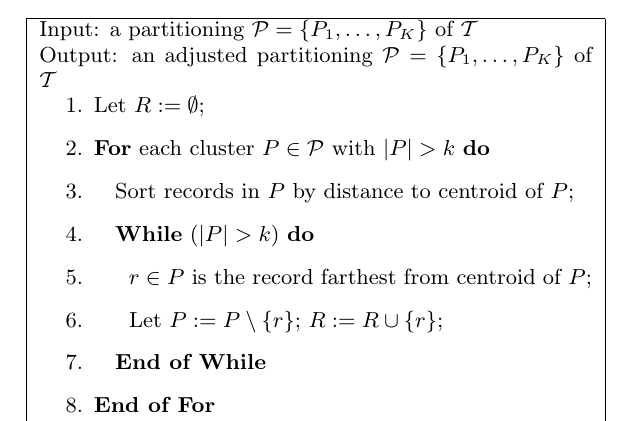

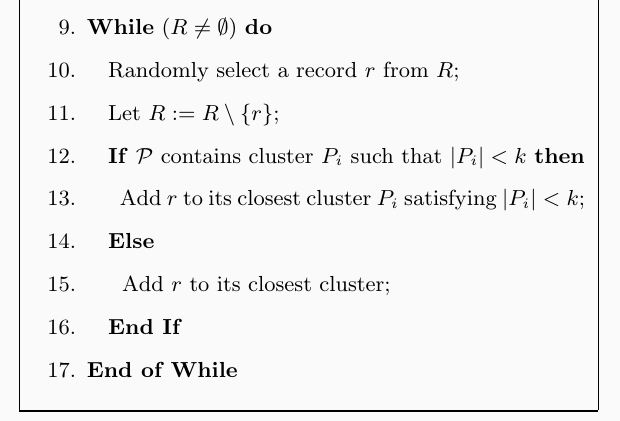

In [36]:
def adjustment_stage(dataset, desired_k = 50):
    """
    
    """
    adjusted_cluster = dataset['equivalence_class'].copy()
    
    record_index     = np.arange(0, dataset.shape[0])
    
    dataset.set_index(record_index, inplace=True)
    
    n_clusters = dataset['equivalence_class'].nunique()
    
    clusters = { cl_id: dataset[dataset.equivalence_class == cl_id].drop('equivalence_class', axis=1).copy()
                 for cl_id in range(n_clusters)}
    centroids = { cl_id: oka_centroid(cluster)
                 for cl_id, cluster in tqdm.tqdm(clusters.items())}
        
    R = []
    
    # Collect records far away from centroids for big clusters
    for cl_id, cluster_data in tqdm.tqdm(clusters.items(), total=n_clusters):
        if cluster_data.shape[0] <= desired_k:
            continue
        
        cluster_data['dist_to_centroid'] = cluster_data.apply(lambda r: 
                                                                  kmember_distance(r.values,
                                                                                   centroids[cl_id],
                                                                                   single_attr_distances),
                                                              axis=1)
        cluster_data.sort_values(by='dist_to_centroid', ascending=False, inplace=True)
        cluster_data.drop('dist_to_centroid', axis=1, inplace=True)
        
        for i in range(0, cluster_data.shape[0] - desired_k):
            record = cluster_data.iloc[i, :]
            
            index = record.__dict__['_name']
            
            # Update the adjusted cluster array so we know this record is no longer in this cluster
            adjusted_cluster[index] = -1
            
            R.append(record)
            
    processed = set()
            
    # Distribute records to clusters where they are needed
    for record in tqdm.tqdm(R):
        min_d = 10000000
        best_cluster = -1
        for cluster_id, cluster in clusters.items():
            if (adjusted_cluster == cluster_id).sum() > desired_k:
                continue
                
            d = kmember_distance(record.values, centroids[cluster_id], single_attr_distances)
            if d <= min_d:
                min_d = d
                best_cluster = cluster_id
        
        index = record.__dict__['_name']
        adjusted_cluster[index] = best_cluster
        processed = processed.union({tuple(record.values.tolist())})
                
    # Distribute remaining records anywhere
    for record in tqdm.tqdm(R):
        if tuple(record.values.tolist()) in processed:
            continue
            
        min_d = 10000000
        best_cluster = -1
        for cluster_id, cluster in clusters.items():
            d = kmember_distance(record.values, centroids[cluster_id], single_attr_distances)
            if d <= min_d:
                min_d = d
                best_cluster = cluster_id
                
        index = record.__dict__['_name']
        adjusted_cluster[index] = best_cluster
        
    dataset['equivalence_class'] = adjusted_cluster
    
    return dataset

In [37]:
adult_df_out = adult_df.copy()

adult_df_out['equivalence_class'] = out_cluster_ids

income_cls = adult_df_out['income_class']
adult_df_out = adjustment_stage(adult_df_out.drop('income_class', axis=1), desired_k = 200)
adult_df_out['income_class'] = income_cls

adult_df_out.head()

100%|██████████| 16976/16976 [00:00<00:00, 236441.63it/s]


,marital_status,native_country,occupation,workclass,relationship,race,sex,age,education_num,capital_gain,capital_loss,hours_per_week,equivalence_class,income_class
0,Never-married,United-States,Adm-clerical,State-gov,Not-in-family,White,Male,39,13,2174,0,40,104,0
1,Married-civ-spouse,United-States,Exec-managerial,Self-emp-not-inc,Husband,White,Male,50,13,0,0,13,145,0
2,Divorced,United-States,Handlers-cleaners,Private,Not-in-family,White,Male,38,9,0,0,40,99,0
3,Married-civ-spouse,United-States,Handlers-cleaners,Private,Husband,Black,Male,53,7,0,0,40,112,0
4,Married-civ-spouse,Cuba,Prof-specialty,Private,Wife,Black,Female,28,13,0,0,40,18,0


In [38]:
adult_df_out.to_csv('data/adult.som.adj.out', index=False)

In [39]:
information_loss(adult_df_out.drop('income_class', axis=1))

98466.89999637491

### Generalization per equivalence class

In [40]:
adult_df_out_gen = adult_df_out.copy()

In [41]:
# __centroids = adult_df_out_gen.drop('income_class', axis=1)\
#                               .groupby('equivalence_class')\
#                               .apply(lambda g: oka_centroid(g.drop('equivalence_class', axis=1).reset_index())).reset_index()

# __centroids.head()

In [42]:
# adult_df_out_gen['generalized_marital'] = adult_df_out_gen['centroids'].apply(lambda c: c[0])

# adult_df_out_gen.head()

In [43]:
# adult_df_out_gen.to_csv('data/adult.som.general.out', index=False)

### Statistics over the equivalence classes / SOM Units 

#### Number of equiv. classes

In [44]:
adult_df_out.equivalence_class.nunique()

162

##### Number of data points per equiv. class

In [45]:
adult_df_out.equivalence_class.value_counts()

159    201
143    201
101    201
85     201
69     201
      ... 
74     201
58     201
42     201
0      201
68     200
Name: equivalence_class, Length: 162, dtype: int64

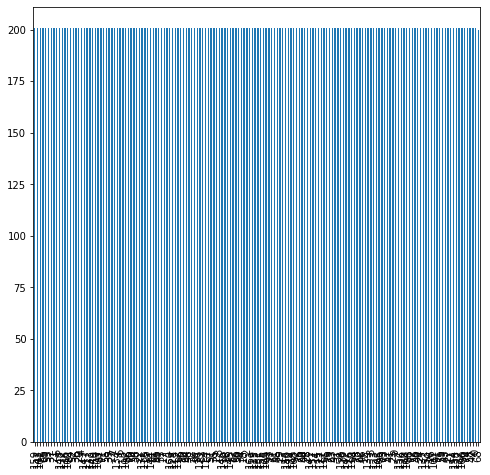

In [46]:
plt.figure(figsize=(8, 8))
adult_df_out.equivalence_class.value_counts().plot(kind='bar', ax=plt.gca())

### Number of clusters with less than 200 instances

In [47]:
nsubk = (adult_df_out.equivalence_class.value_counts() < 200).sum()

print(nsubk, nsubk / adult_df_out.equivalence_class.nunique())

0 0.0


### Number of instances in all insecure clusters

This should drop to 0 once the adjust algorithm is implemented

In [36]:
is_insecure = adult_df_out['equivalence_class'].map((adult_df_out.equivalence_class.value_counts() < 200).to_dict())

is_insecure.sum(), is_insecure.sum() / is_insecure.shape[0]

NameError: name 'adult_df_out' is not defined